In [1]:
# spinning the wheel
import random
import matplotlib.pyplot as plt

def spinwin(n):
    wins = [0, 1, 2]
    cum_win = 0
    ctr = 0
    this_win = random.choice(wins)
    while this_win > 0 and ctr < n:
        cum_win += this_win
        this_win = random.choice(wins)
        ctr += 1
    return cum_win

#print(spinwin(20))
y = [spinwin(200) for i in range(1000)]
#plt.plot(y)
#plt.show()

print(sum(y) / 1000)

2.929


In [9]:
# two tails in a row
import random

def flip():
    return random.choice([0, 1])  # 0=H, 1=T

def game(fee):
    flips = []
    while True:
        flips.append(flip())
        fee -= 1
        if len(flips) > 1:
            if flips[-1] == 1 and flips[-2] == 1:
                return fee

#print(game(5))
total_wins = 0
n_games = 10000
for i in range(n_games):
    total_wins += game(5)
    
print(total_wins / n_games)

-1.0786


# How do parameters drive training data volume?

TODO: adapt to pytorch, consider parameter granularity as improved measure

In [6]:
"""Create a range of logistic regression problems with varying number of parameters.
Use Tensorflow to train models to solve the logistic regression. Plot the relationship
between number of training samples and fscore of the trained models.
For a introduction to logistic regression, please refer to
  https://www.youtube.com/watch?v=tEk6ikTKGYU
"""
import tensorflow as tf
import numpy as np
import scipy.spatial as sp
import matplotlib.pyplot as plt

# The maximum number of model parameters to explore.
kMaxNumParameters = 256
# The maximum multiple of model parameters to use as number of training samples.
kMaxTrainingSamplesMultiple = 16
kMaxNumTrainingSamples = kMaxNumParameters * kMaxTrainingSamplesMultiple
# The threshold to use for classification
kLogisticClassificationThreshold = 0.5
# The regularization parameter (lambda) of cost function.
# Please refer to https://www.youtube.com/watch?v=ef2OPmANLaM 
kRegularizationParameter = 0.1
# The number of explorations for a given number of model parameters. Increase this
# to smooth out the curve for a particular number of model parameters.
kNumModelIterations = 10
# Random data representing the input feature space.
xref_data = np.float32(np.random.uniform(-1, 1, [kMaxNumParameters, kMaxNumTrainingSamples]))
# Random data representing the test samples.
tref_data = np.float32(np.random.uniform(-1, 1, [kMaxNumParameters, 1000]))
# The ratio of training labels that are noisy, i.e, opposite of what they
# really should be. 0.15 indicated 15% of the training labels are noisy.
kNoisyLabelsRatio = 0.15
# Noise to be added to the training labels.
noise = np.random.uniform(0.0, 1.0, [1, kMaxNumTrainingSamples]) < kNoisyLabelsRatio
print("Noise = " , np.float32(np.sum(noise)) / kMaxNumTrainingSamples, "%")

def LogisticClassification(model, data):
    """
    Apply logistic classfication to the data according to:
    y = 1 if sigmoid(model.data) > threshold, 0 otherwise
    Reference: https://www.youtube.com/watch?v=tEk6ikTKGYU
    Args:
    model: The parameters of the logistic regression model.
    data: The instance to be classified.
    Returns:
    Classification result. 
    """
    return 1 / (1 + np.exp(-np.dot(model, data))) > kLogisticClassificationThreshold

def GetFscore(truth, observed):
    """
    Computes f-score based on the differences between supplied truth and observed.
    Reference: https://en.wikipedia.org/wiki/Precision_and_recall
    Args:
    truth: The ground truth against which the f-score is computed.
    observed: The observations for which the f-score is computed.
    Returns:
    The computed f-score.
    """
    # True positives.
    tp = np.sum(np.logical_and(truth, observed))
    # False positives.
    fp = np.sum(np.logical_and(np.logical_not(truth), observed))
    # False negatives.
    fn = np.sum(np.logical_and(truth, np.logical_not(observed)))
    # True negatives.
    tn = np.sum(np.logical_and(np.logical_not(truth), np.logical_not(observed)))
    precision = np.float32(tp) / (tp + fp)
    recall = np.float32(tp) / (tp + fn)
    fscore = 2.0 * precision * recall / (precision + recall) 
    return fscore
  
def RunModel(num_parameters, num_training_samples):
    """
    Creates a logistic regression model of size num_parameters by initializing
    the parameters randomly. Generates ground truth for the model and adds
    the specified amount of noise to the labels. Then uses gradient decent to
    train the model and determines the f-score of the trained model on a 
    randomly generated test.
    Args:
    num_parameters: The number of parameters of the logistic regression model.
    num_training_samples The number of training samples used to train the model.
    Returns:
    The f-score of the trained model. 
    """

    # Generate a model by randomly choosing it's parameters.
    model = np.random.uniform(-1, 1, [1, num_parameters]) 
    # Choose the subset of the total feature space applicable for this model.
    x_data = xref_data[0:num_parameters, 0:num_training_samples]
    # Apply the model on the input features. 
    y_labels_no_noise = LogisticClassification(model, x_data)
    # Generate the training labels by adding some noise to the model output.
    # The xor function flips a fraction of the labels given.
    y_labels = np.logical_xor(y_labels_no_noise, noise[0, 0:num_training_samples])

    # Construct a logistic regression model. Alternatively, one can also use
    # tf.nn.softmax_cross_entropy_with_logits() for compactness. This version
    # makes the model explicit by exposing the basic units.
    W = tf.Variable(tf.random_uniform([1, num_parameters], -1.0, 1.0))
    y = tf.sigmoid(tf.matmul(W, x_data)) 
    # Contruct the regularization term.
    r = tf.mul(kRegularizationParameter, tf.reduce_sum(tf.square(W)))

    # Mimize the L2 loss against the given labels along with square of
    # the parameters for regularization.
    loss = tf.add(tf.nn.l2_loss(tf.sub(y, y_labels)), r)
    optimizer = tf.train.GradientDescentOptimizer(0.5)
    train = optimizer.minimize(loss)

    # For initializing the variables.
    init = tf.initialize_all_variables()

    # Launch the Tensorflow graph
    sess = tf.Session()
    sess.run(init)

    # Fit the plane.
    for step in xrange(0, 1000):
        sess.run(train)

    predicted_model = sess.run(W)

    # The subset of the test data used for this model.
    t_data = tref_data[0:num_parameters, :]
    # The computed test labels.
    yt_data = LogisticClassification(model, t_data)
    # The labels predicated by the model for the test data.
    predicted_data = LogisticClassification(predicted_model, t_data)
    # Return peformance of the model.  
    return GetFscore(yt_data, predicted_data)

# Generate model with number of parameters as 10, 40, 70,..
N = kMaxNumParameters
plots = []
legends = []
for n in [N/8, N/4, N/2, N]:
    if (n < 4):
        continue
    # Collect the performance data for the plot
    data = []
    # Vary the samples as 1x, 2x, 3x.. of parameters
    for samples in range(n, kMaxTrainingSamplesMultiple * n, n):
        score_sum = 0.0
    # Number of times each model is repeated.
    for iter in range(0, kNumModelIterations):
        score = RunModel(n, samples)
        print("Params=", n, " Samples=", samples, " Iter=", iter, " Score=", score)
        score_sum += score
    # Average the score over multiple iterations to smooth out the curves
    data.append(score_sum / kNumModelIterations)
    p, = plt.plot(data, label=str(n))
    plots.append(p)
    legends.append(str(n))
plt.legend(plots, legends)
plt.ylabel("f-score")
plt.xlabel("num-training-samples / num-model-parameters")
plt.show()  

C:\Users\bscho\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\bscho\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\bscho\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\bscho\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

AttributeError: type object 'h5py.h5.H5PYConfig' has no attribute '__reduce_cython__'

In [13]:
# Cantor set

def cantor(n):
    return [0.] + cant(0., 1., n) + [1.]

def cant(x, y, n):
    if n == 0:
        return []

    new_pts = [2.*x/3. + y/3., x/3. + 2.*y/3.]
    return cant(x, new_pts[0], n-1) + new_pts + cant(new_pts[1], y, n-1)

for i in range(4):
    print(i, cantor(i))

0 [0.0, 1.0]
1 [0.0, 0.3333333333333333, 0.6666666666666666, 1.0]
2 [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0]
3 [0.0, 0.037037037037037035, 0.07407407407407407, 0.1111111111111111, 0.2222222222222222, 0.25925925925925924, 0.2962962962962963, 0.3333333333333333, 0.6666666666666666, 0.7037037037037037, 0.7407407407407407, 0.7777777777777777, 0.8888888888888888, 0.9259259259259258, 0.9629629629629629, 1.0]


# Understand feature representations in NNs

https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

Dataset: https://github.com/zalandoresearch/fashion-mnist

improve insights into information requirement and model parameter-data volume dependency

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

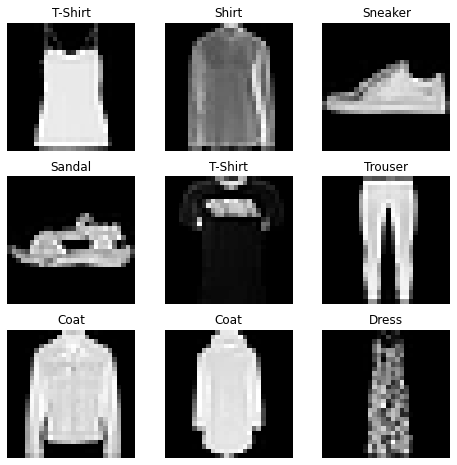

In [2]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [3]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.296402  [    0/60000]
loss: 2.290621  [ 6400/60000]
loss: 2.275864  [12800/60000]
loss: 2.280686  [19200/60000]
loss: 2.264903  [25600/60000]
loss: 2.253909  [32000/60000]
loss: 2.240706  [38400/60000]
loss: 2.218282  [44800/60000]
loss: 2.222968  [51200/60000]
loss: 2.212215  [57600/60000]
Test Error: 
 Accuracy: 47.9%, Avg loss: 0.034628 

Epoch 2
-------------------------------
loss: 2.195521  [    0/60000]
loss: 2.190065  [ 6400/60000]
loss: 2.157072  [12800/60000]
loss: 2.180350  [19200/60000]
loss: 2.123199  [25600/60000]
loss: 2.102728  [32000/60000]
loss: 2.093946  [38400/60000]
loss: 2.043428  [44800/60000]
loss: 2.052193  [51200/60000]
loss: 1.997069  [57600/60000]
Test Error: 
 Accuracy: 56.3%, Avg loss: 0.031422 

Epoch 3
-------------------------------
loss: 2.013556  [    0/60000]
loss: 1.991654  [ 6400/60000]
loss: 1.912071  [12800/60000]
loss: 1.955486  [19200/60000]
loss: 1.847894  [25600/60000]
loss: 1.808135  [32000/600

Predicted class: tensor([4]) Coat


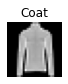

In [7]:
#X = torch.rand(1, 28, 28, device=device)
#X = torch.rand(1, 28, 28)

sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]

#logits = model(X)
logits = model(img)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}", labels_map[y_pred.item()])

figure = plt.figure(figsize=(1, 1))
cols, rows = 1, 1

figure.add_subplot(rows, cols, 1)
plt.title(labels_map[label])
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## weight analysis

In [8]:
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [9]:
model.linear_relu_stack[0].weight

Parameter containing:
tensor([[ 0.0115,  0.0139,  0.0318,  ..., -0.0302,  0.0260,  0.0075],
        [ 0.0036, -0.0315,  0.0085,  ...,  0.0033, -0.0287,  0.0004],
        [-0.0248, -0.0094,  0.0289,  ..., -0.0345, -0.0276,  0.0352],
        ...,
        [ 0.0038,  0.0035,  0.0177,  ...,  0.0305, -0.0150, -0.0314],
        [-0.0154,  0.0178, -0.0204,  ..., -0.0191,  0.0337, -0.0263],
        [ 0.0086,  0.0120,  0.0163,  ...,  0.0078, -0.0251, -0.0114]],
       requires_grad=True)

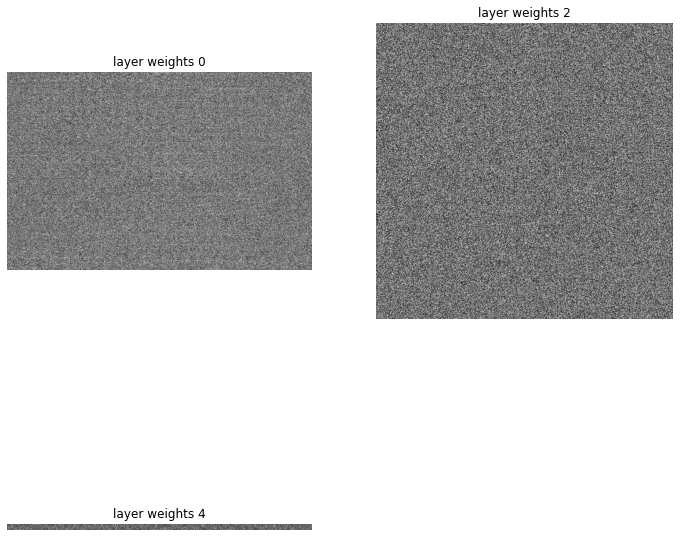

In [10]:
figure = plt.figure(figsize=(12, 12))
cols, rows = 2, 2

for idx, i in enumerate([0, 2, 4]):
    figure.add_subplot(rows, cols, idx+1)
    plt.title("layer weights " + str(i))
    plt.axis("off")
    img = model.linear_relu_stack[i].weight.detach().numpy()
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

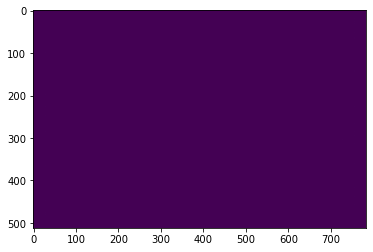

In [11]:
from scipy import fftpack, ndimage
import matplotlib.pyplot as plt
import numpy as np

image = model.linear_relu_stack[0].weight.detach().numpy()
fft2 = fftpack.fft2(image)

plt.imshow(np.abs(fft2) ** 2)
plt.show()

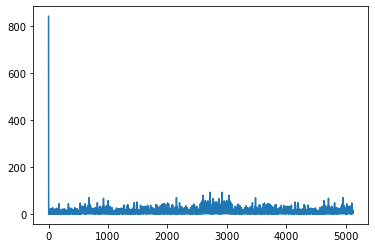

In [12]:
import matplotlib.image as mpimg
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as pl

image = model.linear_relu_stack[4].weight.detach().numpy()

npix = image.shape[0]

fourier_image = np.fft.fftn(image)
fourier_amplitudes = np.abs(fourier_image)**2

kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

kbins = np.arange(0.5, npix // 2 + 1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])

'''Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

pl.loglog(kvals, Abins)
pl.xlabel("$k$")
pl.ylabel("$P(k)$")
pl.tight_layout()'''
#pl.savefig("cloud_power_spectrum.png", dpi = 300, bbox_inches = "tight")
plt.plot(fourier_amplitudes)
pl.show()

# Own dataset

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

tensor([[0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]])


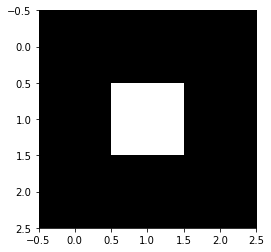

In [2]:
# simple image test
import matplotlib.pyplot as plt

tst_img = torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
print(tst_img)
plt.imshow(tst_img.squeeze(), cmap="gray")
plt.show()

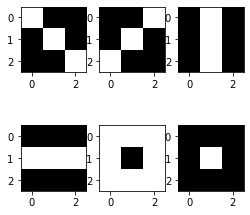

In [3]:
# test image library

test_images = [
    torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]]).float(),
    torch.tensor([[0, 0, 1], [0, 1, 0], [1, 0, 0]]).float(),
    torch.tensor([[0, 1, 0], [0, 1, 0], [0, 1, 0]]).float(),
    torch.tensor([[0, 0, 0], [1, 1, 1], [0, 0, 0]]).float(),
    torch.tensor([[1, 1, 1], [1, 0, 1], [1, 1, 1]]).float(),
    torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]]).float()
]

figure = plt.figure(figsize=(4, 4))
cols, rows = 3, 2
for i in range(1, cols * rows + 1):
    img = test_images[i-1]
    figure.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

see
https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html


Let ID be the Python string that identifies a given sample of the dataset. A good way to keep track of samples and their labels is to adopt the following framework:

Create a dictionary called partition where you gather:

in partition['train'] a list of training IDs
in partition['validation'] a list of validation IDs
Create a dictionary called labels where for each ID of the dataset, the associated label is given by labels[ID]

For example, let's say that our training set contains id-1, id-2 and id-3 with respective labels 0, 1 and 2, with a validation set containing id-4 with label 1. In that case, the Python variables partition and labels look like

>>> partition
{'train': ['id-1', 'id-2', 'id-3'], 'validation': ['id-4']}
and

>>> labels
{'id-1': 0, 'id-2': 1, 'id-3': 2, 'id-4': 1}

folder/
├── my_classes.py
├── pytorch_script.py
└── data/

In [4]:
# labels and partition

nitems = 6
ntrain = 4  # number of items in training set
my_labels = dict({'id-' + str(idx): idx for idx in range(nitems)})
my_partition = dict({'train': [lbl[0] for lbl in my_labels.items() if lbl[1] < ntrain],
               'validation': [lbl[0] for lbl in my_labels.items() if lbl[1] >= ntrain]})

print(my_labels)
print(my_partition)
print(my_partition['train'])

{'id-0': 0, 'id-1': 1, 'id-2': 2, 'id-3': 3, 'id-4': 4, 'id-5': 5}
{'train': ['id-0', 'id-1', 'id-2', 'id-3'], 'validation': ['id-4', 'id-5']}
['id-0', 'id-1', 'id-2', 'id-3']


In [5]:
import torch

class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        #print('ID:', ID, my_labels[ID], test_images[my_labels[ID]], self.labels[ID])

        # Load data and get label
        #X = torch.load('data/' + ID + '.pt')  # e.g. id-1.pt
        X = test_images[my_labels[ID]]
        y = self.labels[ID]

        return X, y

In [6]:
test_images[my_labels[my_partition['train'][2]]]

tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

In [7]:
import torch


# CUDA for PyTorch
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0" if use_cuda else "cpu")
#torch.backends.cudnn.benchmark = True

# Datasets
nitems = 6
ntrain = 4  # number of items in training set
my_labels = dict({'id-' + str(idx): idx for idx in range(nitems)})
my_partition = dict({'train': [lbl[0] for lbl in my_labels.items() if lbl[1] < ntrain],
               'validation': [lbl[0] for lbl in my_labels.items() if lbl[1] >= ntrain]})

# Generators
training_set = Dataset(my_partition['train'], my_labels)
training_generator = torch.utils.data.DataLoader(training_set)

validation_set = Dataset(my_partition['validation'], my_labels)
validation_generator = torch.utils.data.DataLoader(validation_set)

'''# Loop over epochs
for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        # Model computations
        [...]

    # Validation
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in validation_generator:
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Model computations
            [...]'''

for batch, (X, y) in enumerate(training_generator):
    print(batch, (X, y))

0 (tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]]), tensor([0]))
1 (tensor([[[0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.]]]), tensor([1]))
2 (tensor([[[0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.]]]), tensor([2]))
3 (tensor([[[0., 0., 0.],
         [1., 1., 1.],
         [0., 0., 0.]]]), tensor([3]))


In [33]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*3, 2),
            nn.ReLU(),
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, 1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [34]:
learning_rate = 1e-1
batch_size = 1

In [35]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        #print(X, y)
        # Compute prediction and loss
        pred = model(X)
        #print(pred.reshape(-1), y)
        #print(pred.size(), pred.reshape(-1).size(), y.size())
        loss = loss_fn(pred.reshape(-1).float(), y.float())

        # Backpropagation
        #optimizer.zero_grad()
        loss.backward()
        #optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        with torch.no_grad():  # w/o optimizer, just gradient
            for p in model.parameters():
                p.sub_(0.01* p.grad)


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred.reshape(-1).float(), y.float()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [37]:
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(training_generator, model, loss_fn, optimizer)
    test_loop(validation_generator, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.183419  [    0/    4]
Test Error: 
 Accuracy: 0.0%, Avg loss: 10.166895 

Epoch 2
-------------------------------
loss: 1.422037  [    0/    4]
Test Error: 
 Accuracy: 0.0%, Avg loss: 11.857343 

Epoch 3
-------------------------------
loss: 0.918305  [    0/    4]
Test Error: 
 Accuracy: 0.0%, Avg loss: 12.548698 

Epoch 4
-------------------------------
loss: 0.704414  [    0/    4]
Test Error: 
 Accuracy: 0.0%, Avg loss: 14.350583 

Epoch 5
-------------------------------
loss: 0.450094  [    0/    4]
Test Error: 
 Accuracy: 0.0%, Avg loss: 17.058558 

Done!


# weight analysis

In [38]:
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=9, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=1, bias=True)
    (5): ReLU()
  )
)


In [39]:
model.linear_relu_stack[0].weight

Parameter containing:
tensor([[-1.8393e+00,  6.8497e-01, -7.9858e-01,  1.7880e+00, -4.8318e-04,
          1.6189e+00, -8.3742e-01,  6.0335e-01, -1.7848e+00],
        [ 2.1771e-02,  2.3007e-01, -6.1340e-02,  5.4909e-01, -3.8150e-02,
          1.4666e-01,  4.5720e-02,  2.1497e-01, -1.7930e-01]],
       requires_grad=True)

TypeError: Invalid shape (2,) for image data

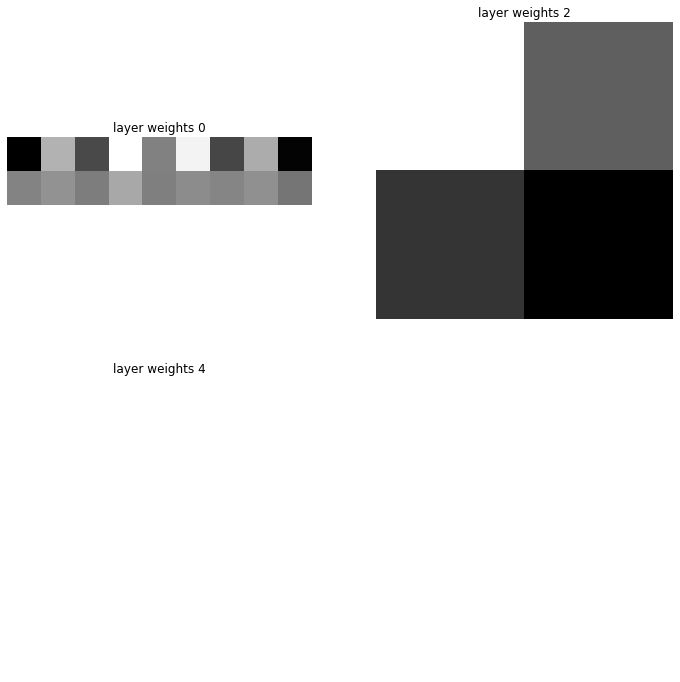

In [40]:
figure = plt.figure(figsize=(12, 12))
cols, rows = 2, 2

for idx, i in enumerate([0, 2, 4]):
    figure.add_subplot(rows, cols, idx+1)
    plt.title("layer weights " + str(i))
    plt.axis("off")
    img = model.linear_relu_stack[i].weight.detach().numpy()
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

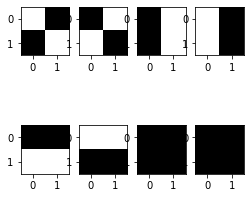

In [3]:
# test image library
import matplotlib.pyplot as plt

test_images = [
    torch.tensor([[1, 0], [0, 1]]).float(),
    torch.tensor([[0, 1], [1, 0]]).float(),
    torch.tensor([[0, 1], [0, 1]]).float(),
    torch.tensor([[1, 0], [1, 0]]).float(),
    torch.tensor([[0, 0], [1, 1]]).float(),
    torch.tensor([[1, 1], [0, 0]]).float(),
    torch.tensor([[1, 1], [1, 1]]).float(),
    torch.tensor([[0, 0], [0, 0]]).float()
]

figure = plt.figure(figsize=(4, 4))
cols, rows = 4, 2
for i in range(1, cols * rows + 1):
    img = test_images[i-1]
    figure.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
import torch

class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        #print('ID:', ID, my_labels[ID], test_images[my_labels[ID]], self.labels[ID])

        # Load data and get label
        #X = torch.load('data/' + ID + '.pt')  # e.g. id-1.pt
        X = test_images[my_labels[ID]]
        y = self.labels[ID]

        return X, y

In [7]:
# Datasets
nitems = 8
ntrain = 6  # number of items in training set
my_labels = dict({'id-' + str(idx): idx for idx in range(nitems)})
my_partition = dict({'train': [lbl[0] for lbl in my_labels.items() if lbl[1] < ntrain],
               'validation': [lbl[0] for lbl in my_labels.items() if lbl[1] >= ntrain]})
test_images[my_labels[my_partition['train'][2]]]

tensor([[0., 1.],
        [0., 1.]])

In [8]:
import torch


# CUDA for PyTorch
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0" if use_cuda else "cpu")
#torch.backends.cudnn.benchmark = True

# Datasets
nitems = 8
ntrain = 6  # number of items in training set
my_labels = dict({'id-' + str(idx): idx for idx in range(nitems)})
my_partition = dict({'train': [lbl[0] for lbl in my_labels.items() if lbl[1] < ntrain],
               'validation': [lbl[0] for lbl in my_labels.items() if lbl[1] >= ntrain]})

# Generators
training_set = Dataset(my_partition['train'], my_labels)
training_generator = torch.utils.data.DataLoader(training_set)

validation_set = Dataset(my_partition['validation'], my_labels)
validation_generator = torch.utils.data.DataLoader(validation_set)

'''# Loop over epochs
for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        # Model computations
        [...]

    # Validation
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in validation_generator:
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Model computations
            [...]'''

for batch, (X, y) in enumerate(training_generator):
    print(batch, (X, y))

0 (tensor([[[1., 0.],
         [0., 1.]]]), tensor([0]))
1 (tensor([[[0., 1.],
         [1., 0.]]]), tensor([1]))
2 (tensor([[[0., 1.],
         [0., 1.]]]), tensor([2]))
3 (tensor([[[1., 0.],
         [1., 0.]]]), tensor([3]))
4 (tensor([[[0., 0.],
         [1., 1.]]]), tensor([4]))
5 (tensor([[[1., 1.],
         [0., 0.]]]), tensor([5]))


In [60]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2*2, 1),
            nn.ReLU(),
            #nn.Linear(2, 2),  # interestingly, the model does not learn with some layer configurations
            #nn.ReLU(),
            #nn.Linear(2, 1),
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [61]:
learning_rate = 1e-1
batch_size = 5

In [62]:
for batch, (X, y) in enumerate(training_generator):
    print(batch, (X, y))
    print('fwd:', model(X))

0 (tensor([[[1., 0.],
         [0., 1.]]]), tensor([0]))
fwd: tensor([[0.2690]], grad_fn=<ReluBackward0>)
1 (tensor([[[0., 1.],
         [1., 0.]]]), tensor([1]))
fwd: tensor([[0.4146]], grad_fn=<ReluBackward0>)
2 (tensor([[[0., 1.],
         [0., 1.]]]), tensor([2]))
fwd: tensor([[1.0730]], grad_fn=<ReluBackward0>)
3 (tensor([[[1., 0.],
         [1., 0.]]]), tensor([3]))
fwd: tensor([[0.]], grad_fn=<ReluBackward0>)
4 (tensor([[[0., 0.],
         [1., 1.]]]), tensor([4]))
fwd: tensor([[0.3000]], grad_fn=<ReluBackward0>)
5 (tensor([[[1., 1.],
         [0., 0.]]]), tensor([5]))
fwd: tensor([[0.3837]], grad_fn=<ReluBackward0>)


In [63]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        #print(X, y)
        # Compute prediction and loss
        pred = model(X)
        #print(pred.reshape(-1), y)
        #print(pred.size(), pred.reshape(-1).size(), y.size())
        loss = loss_fn(pred.reshape(-1).float(), y.float())

        # Backpropagation
        optimizer.zero_grad()
        a = list(model.parameters())[0].clone()  # checking for parameter pre
        loss.backward()
        optimizer.step()
        b = list(model.parameters())[0].clone()  # checking for parameter post
        #torch.equal(a.data, b.data)
        print(a.data, b.data)  # checking for parameter updates to see if model is learning

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        #with torch.no_grad():  # w/o optimizer, just gradient
            #for p in model.parameters():
                #p.sub_(0.01* p.grad)


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred.reshape(-1).float(), y.float()).item()
            #print(pred, pred.argmax(1), y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [64]:
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(training_generator, model, loss_fn, optimizer)
    test_loop(validation_generator, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
tensor([[-0.3572,  0.4468, -0.3262,  0.3321]]) tensor([[-0.4572,  0.4468, -0.3262,  0.2321]])
loss: 0.072365  [    0/    6]
tensor([[-0.4572,  0.4468, -0.3262,  0.2321]]) tensor([[-0.5242,  0.5212, -0.2518,  0.1651]])
tensor([[-0.5242,  0.5212, -0.2518,  0.1651]]) tensor([[-0.5760,  0.6060, -0.1943,  0.2145]])
tensor([[-0.5760,  0.6060, -0.1943,  0.2145]]) tensor([[-0.6184,  0.6755, -0.1472,  0.2550]])
tensor([[-0.6184,  0.6755, -0.1472,  0.2550]]) tensor([[-0.6543,  0.7342, -0.0860,  0.3173]])
tensor([[-0.6543,  0.7342, -0.0860,  0.3173]]) tensor([[-0.6040,  0.7982, -0.0333,  0.3710]])
Test Error: 
 Accuracy: 0.0%, Avg loss: 33.273803 

Epoch 2
-------------------------------
tensor([[-0.6040,  0.7982, -0.0333,  0.3710]]) tensor([[-0.5634,  0.8541,  0.0127,  0.4139]])
loss: 0.080533  [    0/    6]
tensor([[-0.5634,  0.8541,  0.0127,  0.4139]]) tensor([[-0.5276,  0.8985,  0.0468,  0.4516]])
tensor([[-0.5276,  0.8985,  0.0468,  0.4516]]) tensor([[

In [73]:
for batch, (X, y) in enumerate(training_generator):
    print(batch, (X, y))
    print(model(X))
    
print()
    
for batch, (X, y) in enumerate(validation_generator):
    print(batch, (X, y))  # all-0 input gives the bias (1.178)
    print(model(X))

0 (tensor([[[1., 0.],
         [0., 1.]]]), tensor([0]))
tensor([[1.8410]], grad_fn=<ReluBackward0>)
1 (tensor([[[0., 1.],
         [1., 0.]]]), tensor([1]))
tensor([[2.9058]], grad_fn=<ReluBackward0>)
2 (tensor([[[0., 1.],
         [0., 1.]]]), tensor([2]))
tensor([[3.1477]], grad_fn=<ReluBackward0>)
3 (tensor([[[1., 0.],
         [1., 0.]]]), tensor([3]))
tensor([[1.5991]], grad_fn=<ReluBackward0>)
4 (tensor([[[0., 0.],
         [1., 1.]]]), tensor([4]))
tensor([[2.4227]], grad_fn=<ReluBackward0>)
5 (tensor([[[1., 1.],
         [0., 0.]]]), tensor([5]))
tensor([[2.3241]], grad_fn=<ReluBackward0>)

0 (tensor([[[1., 1.],
         [1., 1.]]]), tensor([6]))
tensor([[3.5678]], grad_fn=<ReluBackward0>)
1 (tensor([[[0., 0.],
         [0., 0.]]]), tensor([7]))
tensor([[1.1790]], grad_fn=<ReluBackward0>)


In [69]:
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=1, bias=True)
    (1): ReLU()
  )
)


In [71]:
model.linear_relu_stack[0].weight

Parameter containing:
tensor([[-0.0808,  1.2259,  0.5009,  0.7428]], requires_grad=True)

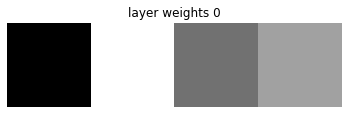

In [78]:
figure = plt.figure(figsize=(6, 6))
cols, rows = 2, 2

plt.title("layer weights " + str(i))
plt.axis("off")
img = model.linear_relu_stack[0].weight.detach().numpy()
plt.imshow(img, cmap="gray")
plt.show()